### inspect avaliable device

In [5]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print("Selected device:", device)


Selected device: mps


### import modules

In [6]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

### init models

In [7]:
from transformers import CLIPTokenizer, CLIPTextModelWithProjection, CLIPVisionModelWithProjection

t_model = CLIPTextModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
tokenizer = CLIPTokenizer.from_pretrained("Searchium-ai/clip4clip-webvid150k")

v_model = CLIPVisionModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
v_model = v_model.eval()

/opt/anaconda3/envs/clip4clip/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set functions

In [8]:
# To extract video embeddings, sample a sequence of frames
def video2image(video_path, frame_rate=2, size=224): # 초당 frame_rate 개수로 균등 추출
    def preprocess(size, n_px):  # 이미지를 전처리하여 텐서로 변환 -> 반환된 텐서는 (추출된 프레임 개수, 채널 수, h, w)의 형태(크기)
        return Compose([
            Resize(size, interpolation=InterpolationMode.BICUBIC),
            CenterCrop(size),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # RGB 채널별 평균과 표준편차로 정규화 수행.
        ])(n_px)  # n_px: PIL 이미지 객체

    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if fps < 1:  # FPS가 유효하지 않은 경우, 빈 배열을 반환하고 오류 메시지
        images = np.zeros([3, size, size], dtype=np.float32)
        print("ERROR: problem reading video file: ", video_path)
    else:
        total_duration = (frameCount + fps - 1) // fps
        start_sec, end_sec = 0, total_duration
        interval = fps / frame_rate
        frames_idx = np.floor(np.arange(start_sec*fps, end_sec*fps, interval))

        ret = True     # 본격적으로 프레임을 읽어와 전처리
        images = np.zeros([len(frames_idx), 3, size, size], dtype=np.float32)

        for i, idx in enumerate(frames_idx):
            cap.set(cv2.CAP_PROP_POS_FRAMES , idx)
            ret, frame = cap.read()
            if not ret: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            last_frame = i
            images[i,:,:,:] = preprocess(size, Image.fromarray(frame).convert("RGB")) # 읽어온 프레임을 PIL 이미지로 변환한 뒤, 전처리를 거쳐 텐서로 변환. -> images 배열에 저장

        images = images[:last_frame+1]
    cap.release()
    video_frames = torch.tensor(images)
    return video_frames

def get_video_embeddings(video_path):
    video_frames = video2image(video_path) # 동영상에서 프레임 이미지의 배열 추출
    video_frames = video_frames.to(v_model.device) # move encoder to GPU

    # CLIP 모델 pixel_values 입력 형식: (N, 3, 224, 224)
    video_embeddings = []
    for i in range(video_frames.shape[0]): # length(추출한 frame 개수)만큼
        with torch.no_grad():
            video_embeddings.append(v_model(pixel_values=video_frames.to(v_model.device))["image_embeds"])

    video_embeddings = torch.stack(video_embeddings).to(v_model.device)  # Move stack to GPU
    video_embeddings = video_embeddings.squeeze(1)

    # Normalizing the embeddings and calculating mean between all embeddings on GPU
    video_embeddings_norm1 = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
    video_embeddings_mean = torch.mean(video_embeddings_norm1, dim=0)
    video_embeddings_norm2 = video_embeddings_mean / video_embeddings_mean.norm(dim=-1, keepdim=True)
    video_embeddings_final = video_embeddings_norm2

    return video_embeddings_final


def get_text_embedding(text):
    inputs = tokenizer(text=text, return_tensors="pt").to(t_model.device) # Move inputs to GPU
    outputs = t_model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
    text_embedding = outputs[0] / outputs[0].norm(dim=-1, keepdim=True)
    print(text_embedding.shape) # torch.Size([1, 512])
    return text_embedding

### test each event

In [9]:
pwd

'/Users/jisu/Desktop/dev/grad-cctv/OMNI/model'

In [12]:
event_dict = {
    "Fall": "A person in falling down indoors",
    "Arson": "Someone set fire indoors, and the flame is still burning",
    "Abandonment": "An item has been left unattended in the store",
    "Damage": "Store equipment being demaged",
    "Theft": "Merchandise taken without payment",
    "Smoking": "Smoking inside the store, holding cigarette in hand"
}

torch.Size([1, 512])


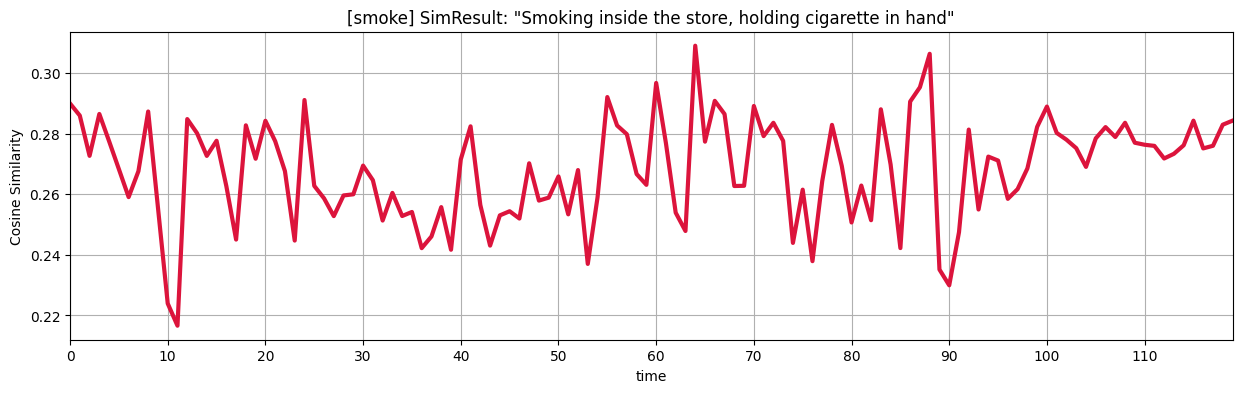

In [11]:
video_file = "../data/raw_vid/smoke-1-full.mp4"
description = "Smoking inside the store, holding cigarette in hand"

video_embeddings = get_video_embeddings(video_file)
text_embedding = get_text_embedding(description)
event_class = video_file.split("/")[-1].split("-")[0]

similarities = torch.matmul(video_embeddings, text_embedding.T).squeeze(1)
plt.figure(figsize=(15,4))
plt.plot(similarities.detach().numpy(), c='crimson', linewidth=3)
plt.title(f"[{event_class}] SimResult: \"{description}\"")
plt.xlim(0, similarities.shape[0]-1)
plt.xticks(np.arange(0, similarities.shape[0], 10))
plt.xlabel("time")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

In [15]:
video_embeddings.shape

torch.Size([120, 512])

In [ ]:
def get_video_embeddings_mp(video_path, window_size=6):
    video_frames = video2image(video_path)  # [num_frames, 3, 224, 224]
    video_frames = video_frames.to(v_model.device)

    # 1. 프레임별 임베딩 계산 [num_frames, dim]
    video_embeddings = []
    for i in range(video_frames.shape[0]):
        with torch.no_grad():
            emb = v_model(pixel_values=video_frames[i].unsqueeze(0))["image_embeds"]  # [1, dim]
        video_embeddings.append(emb.squeeze(0))
    video_embeddings = torch.stack(video_embeddings)  # [num_frames, dim]

    # 2. 정규화
    video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)

    # 3. 슬라이딩 윈도우 mean pooling
    num_frames, dim = video_embeddings.shape
    if num_frames < window_size:
        raise ValueError(f"Video has fewer frames ({num_frames}) than window size ({window_size}).")

    # unfolded = video_embeddings.unfold(dimension=0, size=window_size, step=1)  # [num_windows, window_size, dim]
    # pooled = unfolded.mean(dim=1)  # 의도한 [num_windows, dim]이 아니라 [num_windows, window_size]

    # as_strided로 [num_windows, window_size, dim] view 생성
    num_windows = num_frames - window_size + 1
    stride0, stride1 = video_embeddings.stride()
    strided = video_embeddings.as_strided(
        size=(num_windows, window_size, dim),
        stride=(stride0, stride0, stride1)
    )
    pooled = strided.mean(dim=1)  # [num_windows, dim]

    # 4. 윈도우별 정규화
    pooled = pooled / pooled.norm(dim=-1, keepdim=True)
    print(f"shape of pooled array: {pooled.shape}")

    return pooled  # [num_windows, dim]

shape of pooled array: torch.Size([115, 512])
torch.Size([1, 512])


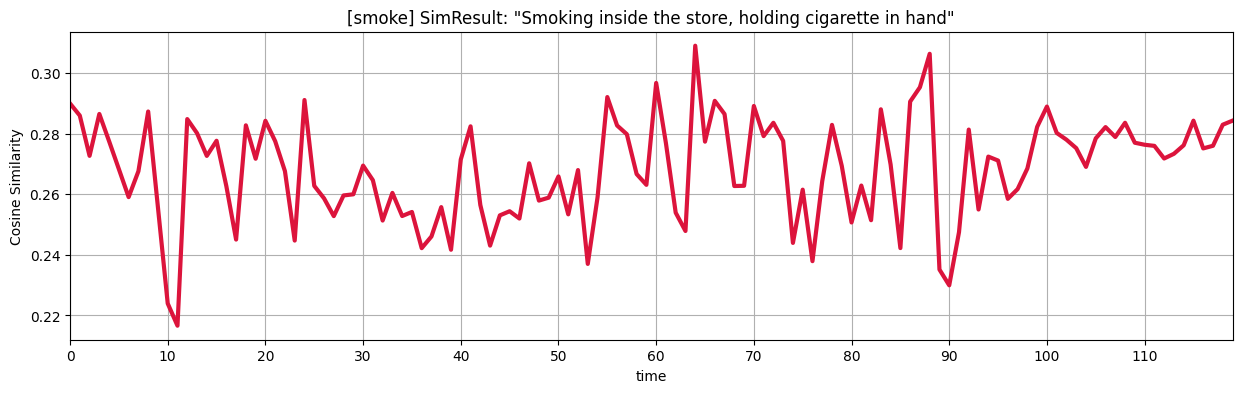

In [18]:
mp_video_embeddings = get_video_embeddings_mp(video_file)
text_embedding = get_text_embedding(description)
event_class = video_file.split("/")[-1].split("-")[0]

mp_similarities = torch.matmul(mp_video_embeddings, text_embedding.T).squeeze(1)
plt.figure(figsize=(15,4))
plt.plot(similarities.detach().numpy(), c='crimson', linewidth=3)
plt.title(f"[{event_class}] SimResult: \"{description}\"")
plt.xlim(0, similarities.shape[0]-1)
plt.xticks(np.arange(0, similarities.shape[0], 10))
plt.xlabel("time")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()